##EVALUATION NOTEBOOK

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import and constants

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 34.1 MB/s 
     |████████████████████████████████| 6.6 MB 62.1 MB/s 
     |████████████████████████████████| 596 kB 73.5 MB/s 
     |████████████████████████████████| 101 kB 13.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import random
import json
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import copy

# Confusion matrix
from sklearn.metrics import confusion_matrix as sk_cm
from sklearn.metrics import ConfusionMatrixDisplay

# PyTorch
import torch
import torch.nn as nn

# Transformers
from transformers import AutoTokenizer
from transformers import AutoModel

# For decoration
from tqdm.auto import tqdm
from termcolor import colored

In [ ]:
# Set the seed for the randoms
def set_random_seed():
    SEED = 104
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
set_random_seed()

# Path
ROOT_PATH = "./drive/MyDrive/NLP/HW2/"
DATASETS_PATH = ROOT_PATH + "data_hw2/"
DEVSET_PATH = "dev.json"
CHECKPOINTS_34_PATH = ROOT_PATH + "checkpoints/"
CHECKPOINTS_1_PATH = ROOT_PATH + "checkpoints_1/"
CHECKPOINTS_2_PATH = ROOT_PATH + "checkpoints_2/"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)
ROLES = ["_", "agent", "asset", "attribute", "beneficiary", "cause", "co-agent", 
         "co-patient", "co-theme", "destination", "experiencer", "extent", 
         "goal", "idiom", "instrument", "location", "material", "patient", 
         "product", "purpose", "recipient", "result", "source", "stimulus", 
         "theme", "time", "topic", "value"]

def encode_roles():
    id2label = {}
    label2id = {}
    for id, label in enumerate(ROLES):
        id2label[id] = label
        label2id[label] = id
    return id2label, label2id
ID_TO_LABEL, LABEL_TO_ID = encode_roles()

device: cuda


# Models

##SRL_Model step 3-4
Two type of models:


*   base_model

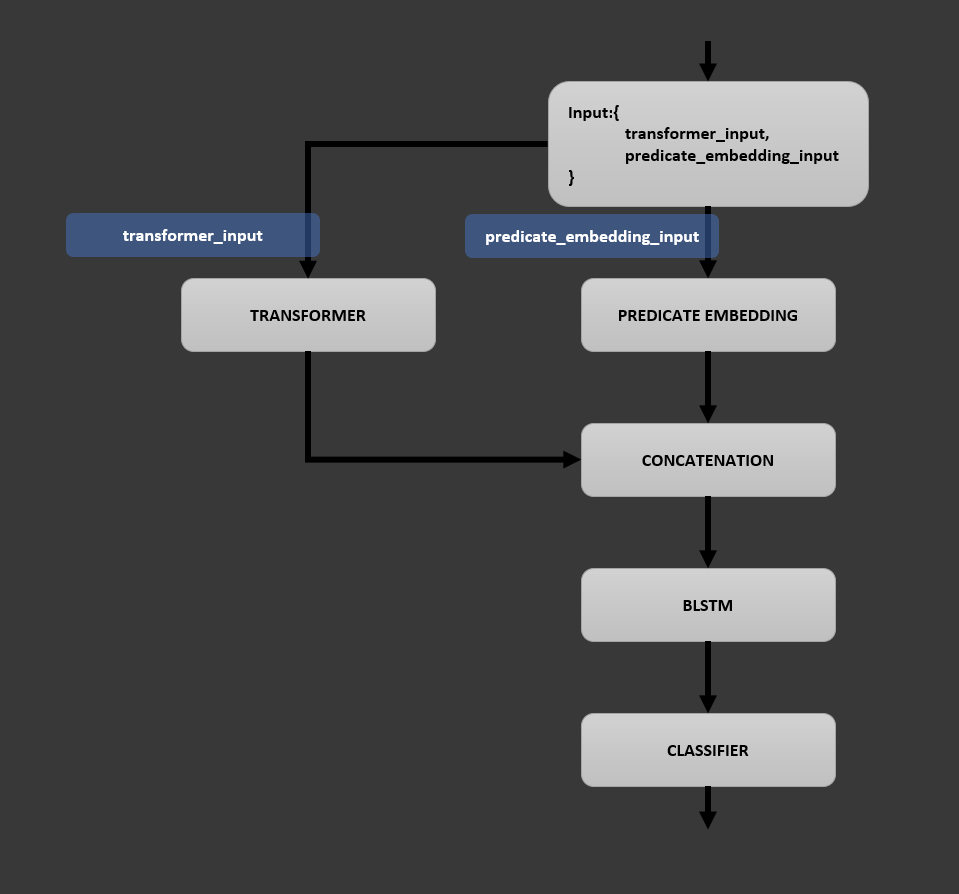


*   base_model_pos 


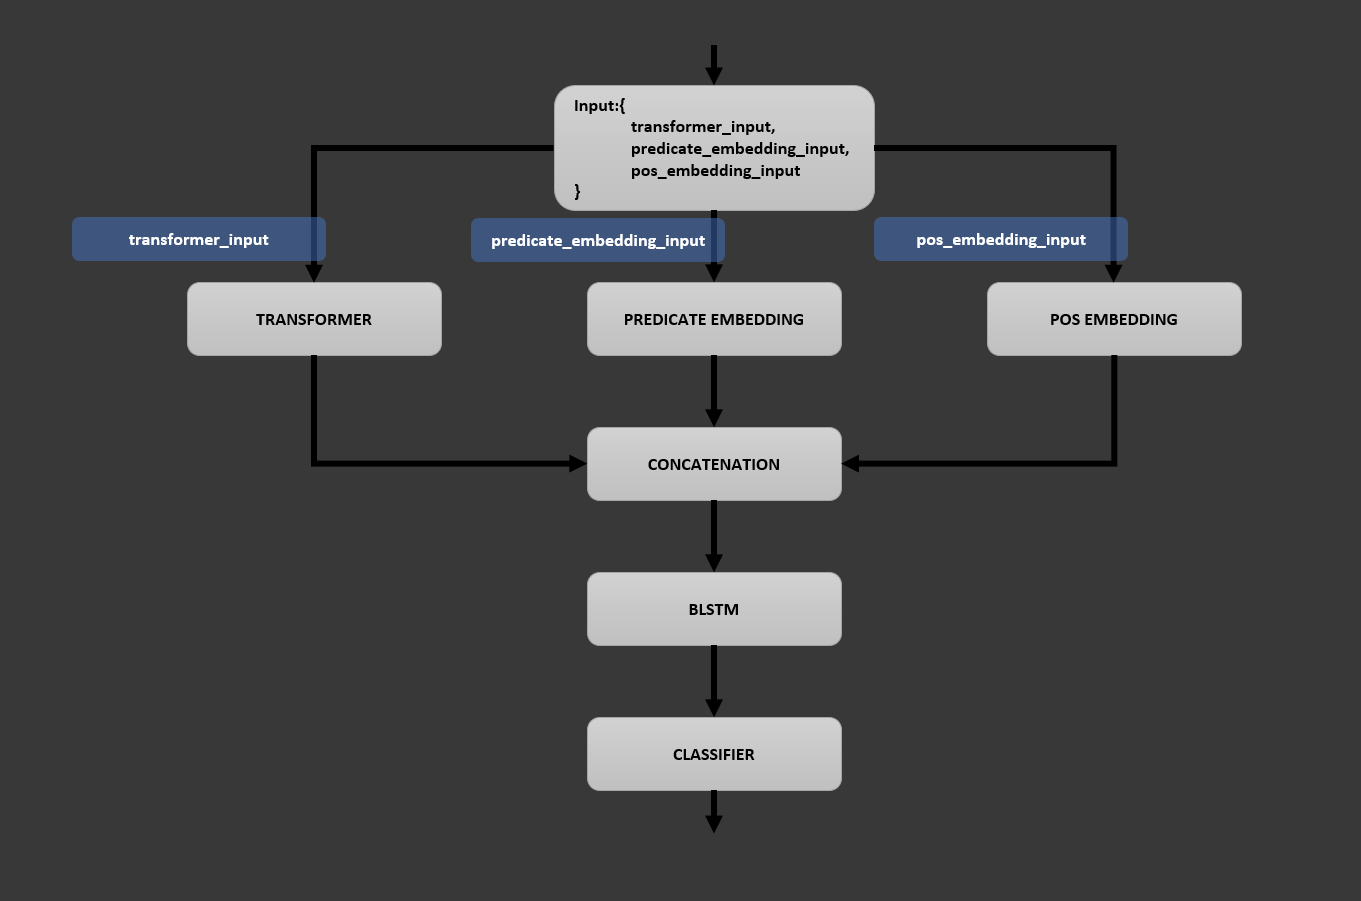

In [ ]:
class SRL_Model_34(nn.Module):
    def __init__(self, hparams):
        super(SRL_Model_34, self).__init__()
        self.model_type = hparams["model_type"]
        # Select the correct model to initialize
        if self.model_type == "base_model":
            self.init_base_model(hparams)
        elif self.model_type == "base_model_pos":
            self.init_base_model_pos(hparams)
        elif self.model_type == "base_model_pos_verbatlas":
            self.init_base_model_pos(hparams)

    def init_base_model(self, hparams):
        # Number of classes
        self.num_labels = hparams["num_labels"]
        
        # Embeddings
        self.predicate_embedding = torch.nn.Embedding(3, hparams["embedding_dim"], padding_idx = 0)

        # Transformer
        self.transformer_model = AutoModel.from_pretrained(hparams["transformer_name"], output_hidden_states=True)
        transformer_output_dim = self.transformer_model.config.hidden_size + hparams["embedding_dim"]            

        # LSTM
        self.lstm = nn.LSTM(transformer_output_dim,
                            hparams["hidden_dim_LSTM"],
                            bidirectional = hparams["bidirectional"],
                            num_layers = hparams["num_layers_LSTM"], 
                            dropout = 0,
                            batch_first = True)
    
        # If is the LSTM is bidirectional, then the output dimension is duplicated
        lstm_output_dim = hparams["hidden_dim_LSTM"] if hparams["bidirectional"] is False else hparams["hidden_dim_LSTM"] * 2
        
        # Classifier
        self.classifier = nn.Linear(lstm_output_dim, hparams["num_labels"])

    def init_base_model_pos(self, hparams):
        # Number of classes
        self.num_labels = hparams["num_labels"]
        
        # Embeddings
        self.predicate_embedding = torch.nn.Embedding(3, hparams["embedding_dim"], padding_idx = 0)
        self.pos_embedding = torch.nn.Embedding(hparams["pos_number"], hparams["pos_dim"], padding_idx = 0)

        # Transformer
        self.transformer_model = AutoModel.from_pretrained(hparams["transformer_name"], output_hidden_states=True)

        transformer_output_dim = self.transformer_model.config.hidden_size + hparams["embedding_dim"] + hparams["pos_dim"]
        
        # LSTM
        self.lstm = nn.LSTM(transformer_output_dim,
                            hparams["hidden_dim_LSTM"],
                            bidirectional = hparams["bidirectional"],
                            num_layers = hparams["num_layers_LSTM"], 
                            dropout = 0,
                            batch_first = True)
    
        # If is the LSTM is bidirectional, then the output dimension is duplicated
        lstm_output_dim = hparams["hidden_dim_LSTM"] if hparams["bidirectional"] is False else hparams["hidden_dim_LSTM"] * 2
        
        # Classifier
        self.classifier = nn.Linear(lstm_output_dim, hparams["num_labels"])

    def forward(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
        predicate_idx: torch.Tensor = None,
        pos_idx: torch.Tensor = None,
        compute_predictions: bool = False
    ) -> torch.Tensor:
        # Select the correct forward
        if self.model_type == "base_model":
            return self.forward_base_model(
                input_ids,
                attention_mask,
                token_type_ids,
                predicate_idx
            )
        elif self.model_type == "base_model_pos":
            return self.forward_base_model_pos(
                input_ids,
                attention_mask,
                token_type_ids,
                predicate_idx,
                pos_idx
            )
        elif self.model_type == "base_model_pos_verbatlas":
            return self.forward_base_model_pos(
                input_ids,
                attention_mask,
                token_type_ids,
                predicate_idx,
                pos_idx
            )

    def forward_base_model(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
        predicate_idx: torch.Tensor = None,
    ) -> torch.Tensor:
        transformer_input = {
            "input_ids": input_ids, 
            "attention_mask": attention_mask
        }
        if token_type_ids != None:
            transformer_input["token_type_ids"] = token_type_ids
        transformers_outputs = self.transformer_model(**transformer_input)
        transformers_outputs_sum = torch.stack(transformers_outputs.hidden_states[-4:], dim=0).sum(dim=0)

        embedding = self.predicate_embedding(predicate_idx).squeeze(2)
        tr_out_with_predicate = torch.cat((transformers_outputs_sum, embedding), dim = -1)

        o, (h, c) = self.lstm(tr_out_with_predicate)
        logits = self.classifier(o)
        
        output = {"logits": logits}
        
        predictions = logits.argmax(dim=-1)
        output["predictions"] = predictions
        return output
    
    def forward_base_model_pos(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
        predicate_idx: torch.Tensor = None,
        pos_idx: torch.Tensor = None
    ) -> torch.Tensor:
        transformer_input = {
          "input_ids": input_ids, 
          "attention_mask": attention_mask
        }
        if token_type_ids != None:
          transformer_input["token_type_ids"] = token_type_ids
        transformers_outputs = self.transformer_model(**transformer_input)
        transformers_outputs_sum = torch.stack(transformers_outputs.hidden_states[-4:], dim=0).sum(dim=0)

        predicate_embedding = self.predicate_embedding(predicate_idx).squeeze(2)

        """
        This "if" is an alternative found at the last minute to solve 
        a problem while still getting almost identical results. 
        Asking if I could use the "pos_tags" field, I was told yes 
        discovering in the end that for steps 1-2, rightly, are not available, 
        and consequently in the "1234" or "234" mode the model that handles 
        steps 3-4 could not handle "pos_tags". 
        Reason why, if I am in mode "34" everything is normal, 
        while in modes "1234" and "234" this trick of duplicate predicate_embedding is used
        """
        if pos_idx is not None:
            pos_embedding = self.pos_embedding(pos_idx).squeeze(2)
            tr_out_with_predicate = torch.cat((transformers_outputs_sum, predicate_embedding, pos_embedding), dim = -1)
        else:
            tr_out_with_predicate = torch.cat((transformers_outputs_sum, predicate_embedding, predicate_embedding), dim = -1)

        o, (h, c) = self.lstm(tr_out_with_predicate)
        logits = self.classifier(o)
        
        output = {"logits": logits}

        predictions = logits.argmax(dim=-1)
        output["predictions"] = predictions
        return output

##SRL_Model step 1
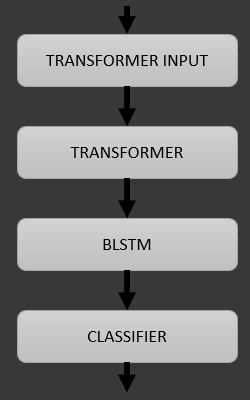

In [ ]:
class SRL_Model_1(nn.Module):
    def __init__(self, hparams):
        super(SRL_Model_1, self).__init__()
        # Number of classes
        self.num_labels = hparams["num_labels"]

        # Transformer
        self.transformer_model = AutoModel.from_pretrained(hparams["transformer_name"], output_hidden_states=True)
        transformer_output_dim = self.transformer_model.config.hidden_size

        # LSTM
        self.lstm = nn.LSTM(transformer_output_dim,
                            hparams["hidden_dim_LSTM"],
                            bidirectional = hparams["bidirectional"],
                            num_layers = hparams["num_layers_LSTM"], 
                            dropout = 0,
                            batch_first = True)
    
        # If is the LSTM is bidirectional, then the output dimension is duplicated
        lstm_output_dim = hparams["hidden_dim_LSTM"] if hparams["bidirectional"] is False else hparams["hidden_dim_LSTM"] * 2
        
        # Classifier
        self.classifier = nn.Linear(lstm_output_dim, hparams["num_labels"])
    
    def forward(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
    ) -> torch.Tensor:
        transformer_input = {
          "input_ids": input_ids, 
          "attention_mask": attention_mask
        }
        if token_type_ids != None:
          transformer_input["token_type_ids"] = token_type_ids
        transformers_outputs = self.transformer_model(**transformer_input)
        transformers_outputs_sum = torch.stack(transformers_outputs.hidden_states[-4:], dim=0).sum(dim=0)

        o, (h, c) = self.lstm(transformers_outputs_sum)
        logits = self.classifier(o)        

        output = {"logits": logits}
        predictions = logits.argmax(dim=-1)
        output["predictions"] = predictions
        return output

##SRL_Model step 2
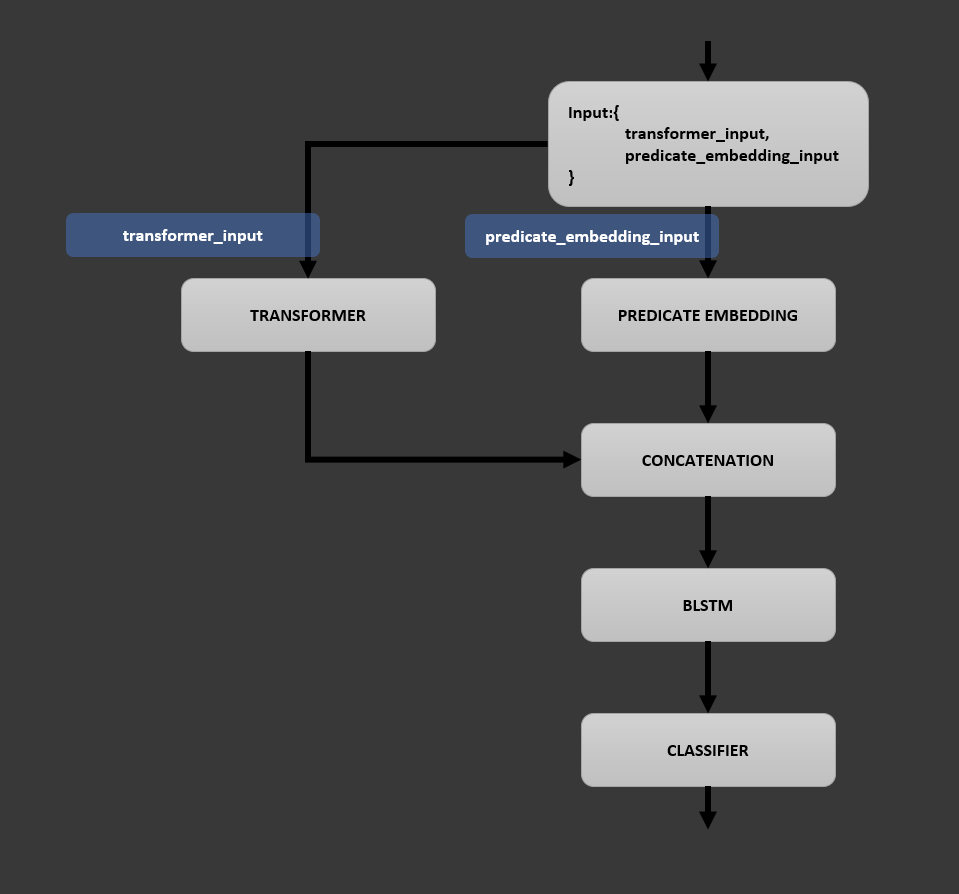

In [ ]:
class SRL_Model_2(nn.Module):
    def __init__(self, hparams):
        super(SRL_Model_2, self).__init__()
        # Number of classes
        self.num_labels = hparams["num_labels"]

        # Embeddings
        self.predicate_embedding = torch.nn.Embedding(3, hparams["embedding_dim"], padding_idx = 0)

        # Transformer
        self.transformer_model = AutoModel.from_pretrained(hparams["transformer_name"], output_hidden_states=True)
        transformer_output_dim = self.transformer_model.config.hidden_size + hparams["embedding_dim"]
        
        # LSTM
        self.lstm = nn.LSTM(transformer_output_dim,
                            hparams["hidden_dim_LSTM"],
                            bidirectional = hparams["bidirectional"],
                            num_layers = hparams["num_layers_LSTM"], 
                            dropout = 0,
                            batch_first = True)
    
        # If is the LSTM is bidirectional, then the output dimension is duplicated
        lstm_output_dim = hparams["hidden_dim_LSTM"] if hparams["bidirectional"] is False else hparams["hidden_dim_LSTM"] * 2
        
        # Classifier
        self.classifier = nn.Linear(lstm_output_dim, hparams["num_labels"])
    
    def forward(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
        predicate_idx: torch.Tensor = None,
    ) -> torch.Tensor:
        transformer_input = {
          "input_ids": input_ids, 
          "attention_mask": attention_mask
        }
        if token_type_ids != None:
          transformer_input["token_type_ids"] = token_type_ids
        transformers_outputs = self.transformer_model(**transformer_input)
        transformers_outputs_sum = torch.stack(transformers_outputs.hidden_states[-4:], dim=0).sum(dim=0)

        embedding = self.predicate_embedding(predicate_idx).squeeze(2)
        tr_out_with_predicate = torch.cat((transformers_outputs_sum, embedding), dim = -1)

        o, (h, c) = self.lstm(tr_out_with_predicate)
        logits = self.classifier(o)

        output = {"logits": logits}
        predictions = logits.argmax(dim=-1)
        output["predictions"] = predictions
        return output

#Utility functions
Copied from the "utils.py" file

In [ ]:
def evaluate_predicate_identification(labels, predictions, null_tag="_"):
    true_positives, false_positives, false_negatives = 0, 0, 0
    for sentence_id in labels:
        gold_predicates = labels[sentence_id]["predicates"]
        pred_predicates = predictions[sentence_id]["predicates"]
        for g, p in zip(gold_predicates, pred_predicates):
            if g != null_tag and p != null_tag:
                true_positives += 1
            elif p != null_tag and g == null_tag:
                false_positives += 1
            elif g != null_tag and p == null_tag:
                false_negatives += 1
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    return {
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

def evaluate_predicate_disambiguation(labels, predictions, null_tag="_"):
    true_positives, false_positives, false_negatives = 0, 0, 0
    for sentence_id in labels:
        gold_predicates = labels[sentence_id]["predicates"]
        pred_predicates = predictions[sentence_id]["predicates"]
        for g, p in zip(gold_predicates, pred_predicates):
            if g != null_tag and p != null_tag:
                if p == g:
                    true_positives += 1
                else:
                    false_positives += 1
                    false_negatives += 1
            elif p != null_tag and g == null_tag:
                false_positives += 1
            elif g != null_tag and p == null_tag:
                false_negatives += 1
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    return {
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

def evaluate_argument_identification(labels, predictions, null_tag="_"):
    true_positives, false_positives, false_negatives = 0, 0, 0
    for sentence_id in labels:
        gold = labels[sentence_id]["roles"]
        pred = predictions[sentence_id]["roles"]
        predicate_indices = set(gold.keys()).union(pred.keys())
        for idx in predicate_indices:
            if idx in gold and idx not in pred:
                false_negatives += sum(1 for role in gold[idx] if role != null_tag)
            elif idx in pred and idx not in gold:
                false_positives += sum(1 for role in pred[idx] if role != null_tag)
            else:  # idx in both gold and pred
                for r_g, r_p in zip(gold[idx], pred[idx]):
                    if r_g != null_tag and r_p != null_tag:
                        true_positives += 1
                    elif r_g != null_tag and r_p == null_tag:
                        false_negatives += 1
                    elif r_g == null_tag and r_p != null_tag:
                        false_positives += 1

    precision = true_positives / (true_positives + false_positives + 0.00000000001)
    recall = true_positives / (true_positives + false_negatives + 0.00000000001)
    f1 = 2 * (precision * recall) / (precision + recall + 0.00000000001)
    return {
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


def evaluate_argument_classification(labels, predictions, null_tag="_"):
    true_positives, false_positives, false_negatives = 0, 0, 0
    for sentence_id in labels:
        gold = labels[sentence_id]["roles"]
        pred = predictions[sentence_id]["roles"]
        predicate_indices = set(gold.keys()).union(pred.keys())

        for idx in predicate_indices:
            if idx in gold and idx not in pred:
                false_negatives += sum(1 for role in gold[idx] if role != null_tag)
            elif idx in pred and idx not in gold:
                false_positives += sum(1 for role in pred[idx] if role != null_tag)
            else:  # idx in both gold and pred
                for r_g, r_p in zip(gold[idx], pred[idx]):
                    if r_g != null_tag and r_p != null_tag:
                        if r_g == r_p:
                            true_positives += 1
                        else:
                            false_positives += 1
                            false_negatives += 1
                    elif r_g != null_tag and r_p == null_tag:
                        false_negatives += 1
                    elif r_g == null_tag and r_p != null_tag:
                        false_positives += 1

    precision = true_positives / (true_positives + false_positives + 0.00000000001)
    recall = true_positives / (true_positives + false_negatives + 0.00000000001)
    f1 = 2 * (precision * recall) / (precision + recall + 0.00000000001)
    return {
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

def _get_table_line(a, b, c):
    if isinstance(b, float):
        b = "{:0.2f}".format(b)
    if isinstance(c, float):
        c = "{:0.2f}".format(c)

    line = "{:^20}|{:^20}|{:^20}".format(a, b, c)
    return line

def print_table(title, results):
    header = _get_table_line("", "Gold Positive", "Gold Negative")
    header_sep = "=" * len(header)

    first_line = _get_table_line(
        "Pred Positive", results["true_positives"], results["false_positives"]
    )
    second_line = _get_table_line("Pred Negative", results["false_negatives"], "")

    precision = "Precision = {:0.4f}".format(results["precision"])
    recall = "Recall    = {:0.4f}".format(results["recall"])
    f1 = "F1 score  = {:0.4f}".format(results["f1"])

    output = "{}\n\n{}\n{}\n{}\n{}\n\n\n{}\n{}\n{}\n\n\n".format(
        title.upper(),
        header,
        header_sep,
        first_line,
        second_line,
        precision,
        recall,
        f1,
    )
    return output

def read_dataset(path: str):
    with open(path) as f:
        dataset = json.load(f)

    sentences, labels = {}, {}
    for sentence_id, sentence in dataset.items():
        sentence_id = sentence_id
        sentences[sentence_id] = {
            "words": sentence["words"],
            "lemmas": sentence["lemmas"],
            "pos_tags": sentence["pos_tags"],
            "dependency_heads": [int(head) for head in sentence["dependency_heads"]],
            "dependency_relations": sentence["dependency_relations"],
            "predicates": sentence["predicates"],
        }

        labels[sentence_id] = {
            "predicates": sentence["predicates"],
            "roles": {int(p): r for p, r in sentence["roles"].items()}
            if "roles" in sentence
            else dict(),
        }
    return sentences, labels

# The confusion matrix is not copied, it is mine
def confusion_matrix_34(predictions, labels, model_name, language):
    # ARGUMENT CLASSIFICATION
    c = ROLES
    all_labels = []
    all_predictions = []
    for roles_p, roles_l in zip(predictions.values(), labels.values()):
        for role_l in roles_l["roles"].values():
            all_labels += role_l
        for role_p in roles_p["roles"].values():
            all_predictions += role_p
    confusion_matrix = sk_cm(all_labels, all_predictions, labels=c, normalize = "true")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=c)
    fig, ax = plt.subplots(figsize=(50,50))
    disp.plot(ax=ax)
    plt.grid(False)
    plt.title("Argument classification")
    plt.show()
    # SAVE THE IMAGE OF THE PLOT
    fig.savefig("conf_mat/confusion_matrix_arg_classification_" + model_name + "_" + language + ".jpg")

    # ARGUMENT IDENTIFICATION
    c = ["is_not_argument", "is_argument"]
    for i, (p, l) in enumerate(zip(all_predictions, all_labels)):
        if p == "_":
            all_predictions[i] = c[0]
        else:
            all_predictions[i] = c[1]
        if l == "_":
            all_labels[i] = c[0]
        else:
            all_labels[i] = c[1]
    confusion_matrix = sk_cm(all_labels, all_predictions, labels=c, normalize = "true")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=c)
    fig, ax = plt.subplots(figsize=(13,13))
    disp.plot(ax=ax)
    plt.grid(False)
    plt.title("Argument identification")
    plt.show()
    # SAVE THE IMAGE OF THE PLOT
    fig.savefig("conf_mat/confusion_matrix_arg_identification_" + model_name + "_" + language + ".jpg")

# Student model
A copy that emulates what happens in "implementation.py"

In [ ]:
class StudentModel():
    def __init__(
            self, 
            device, 
            language: str,
            chk_name_34: str, 
            chk_name_1: str = None, 
            chk_name_2: str = None, 
            model_type: str = "base_model",
            step: str = "34"
        ):
        """
        Args:
            device: "cuda" or "cpu"
            language: "EN", "ES" or "FR" to load the specific checkpoints
            chk_name_34: name of the checkpoint of the model for the step 3-4
            chk_name_1: name of the checkpoint of the model for the step 1
            chk_name_2: name of the checkpoint of the model for the step 2
            model_type: type of the model to use for step 3-4
            step: the modality of the evaluation: "34", "234" or "1234"
        """
        self.step = step
        self.language = language
        self.device = device

        self.chk_name_34 = chk_name_34
        self.chk_name_1 = chk_name_1
        self.chk_name_2 = chk_name_2

        self.model_type = model_type
        self.roles = ["_", "agent", "asset", "attribute", "beneficiary", "cause", "co-agent", 
                        "co-patient", "co-theme", "destination", "experiencer", "extent", 
                        "goal", "idiom", "instrument", "location", "material", "patient", 
                        "product", "purpose", "recipient", "result", "source", "stimulus", 
                        "theme", "time", "topic", "value"]
        if self.model_type == "base_model_pos_crf":
            self.roles.append("<pad>")
        
        self.pos = ["<PAD>", "ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", 
                    "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"]
        self.id2label, self.label2id = self.encode_roles(self.roles)
        self.id2pos, self.pos2id = self.encode_pos(self.pos)
        
        self.predicates_label, self.id2predicate_label, self.predicate2id_label = self.encode_predicates()
        self.srl_model_34 = None
        self.srl_model_1 = None
        self.srl_model_2 = None
        self.n = 0
    
    def encode_predicates(self):
        """
        Method used to read the predicates from VerbAtlas.
        Return:
            predicates_label: list of predicates
            id2predicate_label: map the id to a predicate
            predicate2id_label: map the predicate to an id
        """
        with open(ROOT_PATH + "verbatlas/VA_frame_info.tsv", mode='r', encoding='utf-8') as json_file:
            json_list_verbatlas_info = list(json_file)
        id2predicate_label = {0: "_"}
        predicate2id_label = {"_": 0}
        predicates_label = ["_"]
        for id, info in enumerate(json_list_verbatlas_info[1:]):
            info_splitted = info.replace("\n", "").split("\t")
            name = info_splitted[1].upper()
            predicates_label.append(name)
            id2predicate_label[id+1] = name
            predicate2id_label[name] = id+1
        return predicates_label, id2predicate_label, predicate2id_label

    def encode_pos(self, pos):
        """
        Method used to encode the pos_tags.
        Return:
            id2pos: map the id to a pos_tag
            pos2id: map the pos_tag to an id
        """
        id2pos= {}
        pos2id = {}
        for id, label in enumerate(pos):
            id2pos[id] = label
            pos2id[label] = id
        return id2pos, pos2id

    def encode_roles(self, roles):
        """
        Method used to encode the roles.
        Return:
            id2label: map the id to a role
            label2id: map the role to an id
        """
        id2label = {}
        label2id = {}
        for id, label in enumerate(roles):
            id2label[id] = label
            label2id[label] = id
        return id2label, label2id

    def read_from_verbatlas(self):
        """
        Method used to read information from VerbAtlas, 
        specifically the first two ARGS for each predicate, 
        saving everything in dictionaries.
        Return:
            id2predicate: map the id to a predicate.
            predicate2id: map the predicate to an id.
            predicate2args: map a predicate to a list of the first two args
        """
        with open(ROOT_PATH + "verbatlas/VA_frame_info.tsv", mode='r', encoding='utf-8') as json_file:
            json_list_verbatlas_info = list(json_file)
        with open(ROOT_PATH + "verbatlas/VA_frame_pas.tsv", mode='r', encoding='utf-8') as json_file:
            json_list_verbatlas_pas = list(json_file)
        id2predicate = {}
        predicate2id = {}
        predicate2args = defaultdict(lambda: [])
        for info, pas in zip(json_list_verbatlas_info[1:], json_list_verbatlas_pas[1:]):
            info_splitted = info.replace("\n", "").split("\t")
            pas_splitted = pas.replace("\n", "").split("\t")
            name = info_splitted[1].upper()
            id = info_splitted[0]
            id2predicate[id] = name
            predicate2id[name] = id
            for arg in pas_splitted[1:3]:
                predicate2args[name].append(arg.lower())
        predicate2args = dict(predicate2args)
        return id2predicate, predicate2id, predicate2args

    def decode_hparams(self, chk_name):
        """
        Method used to get the hparams from a checkpoint name.
        Return:
            hparams: dictionary with the hparams
        """
        hparams = {}
        if chk_name != None:
            for attribute in chk_name.replace(".pt", "").split("___"):
                key = attribute.split("__")[0]
                value = attribute.split("__")[1].replace("%", "/")
                if (key != "transformer_name" and key != "name"):
                    if value == "True":
                        value = True
                    elif  value == "False":
                        value = False
                    elif '.' in value or "1e-" in value:
                        value = float(value)
                    else:
                        value = int(value)
                hparams[key] = value
        return hparams

    def predict(self, sentence):
        """
        Args:
            sentence: a dictionary that represents an input sentence, for example:
                - If you are doing argument identification + argument classification:
                    {
                        "words":
                            [  "In",  "any",  "event",  ",",  "Mr.",  "Englund",  "and",  "many",  "others",  "say",  "that",  "the",  "easy",  "gains",  "in",  "narrowing",  "the",  "trade",  "gap",  "have",  "already",  "been",  "made",  "."  ]
                        "lemmas":
                            ["in", "any", "event", ",", "mr.", "englund", "and", "many", "others", "say", "that", "the", "easy", "gain", "in", "narrow", "the", "trade", "gap", "have", "already", "be", "make",  "."],
                        "predicates":
                            ["_", "_", "_", "_", "_", "_", "_", "_", "_", "AFFIRM", "_", "_", "_", "_", "_", "REDUCE_DIMINISH", "_", "_", "_", "_", "_", "_", "MOUNT_ASSEMBLE_PRODUCE", "_" ],
                    },
                - If you are doing predicate disambiguation + argument identification + argument classification:
                    {
                        "words": [...], # SAME AS BEFORE
                        "lemmas": [...], # SAME AS BEFORE
                        "predicates":
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0 ],
                    },
                - If you are doing predicate identification + predicate disambiguation + argument identification + argument classification:
                    {
                        "words": [...], # SAME AS BEFORE
                        "lemmas": [...], # SAME AS BEFORE
                        # NOTE: you do NOT have a "predicates" field here.
                    },
        Returns:
            A dictionary with your predictions:
                - If you are doing argument identification + argument classification:
                    {
                        "roles": list of lists, # A list of roles for each predicate in the sentence.
                    }
                - If you are doing predicate disambiguation + argument identification + argument classification:
                    {
                        "predicates": list, # A list with your predicted predicate senses, one for each token in the input sentence.
                        "roles": dictionary of lists, # A list of roles for each pre-identified predicate (index) in the sentence.
                    }
                - If you are doing predicate identification + predicate disambiguation + argument identification + argument classification:
                    {
                        "predicates": list, # A list of predicate senses, one for each token in the sentence, null ("_") included.
                        "roles": dictionary of lists, # A list of roles for each predicate (index) you identify in the sentence.
                    }
        """
        # For the first sentence, initialize the models
        if (self.srl_model_34 == None):
            chk_name_1 = self.chk_name_1
            chk_name_2 = self.chk_name_2
            chk_name_34 = self.chk_name_34
            # Get the information from each checkpoint name
            hparams_1 = self.decode_hparams(chk_name_1)
            hparams_2 = self.decode_hparams(chk_name_2)
            hparams_34 = self.decode_hparams(chk_name_34)

            # If the modality is "1234"
            if self.step == "1234":
                # The labels are ["_", "predicate"]
                hparams_1["num_labels"] = 2
                hparams_1["num_layers_LSTM"] = 2
                hparams_1["bidirectional"] = True
                # Load and set to eval the model for step 1
                self.srl_model_1 = SRL_Model_1(hparams_1).to(self.device)
                self.srl_model_1.load_state_dict(torch.load(CHECKPOINTS_1_PATH + self.language + "/" + chk_name_1, map_location=torch.device(self.device)))
                self.srl_model_1.eval()
                self.tokenizer_1 = AutoTokenizer.from_pretrained(hparams_1["transformer_name"])

            # If the modality is "1234" or "234"
            if self.step == "234" or self.step == "1234":
                # The labels are the number of type of predicates in VerbAtlas
                hparams_2["num_labels"] = len(self.predicates_label)
                hparams_2["num_layers_LSTM"] = 2
                hparams_2["bidirectional"] = True
                # Load and set to eval the model for step 2
                self.srl_model_2 = SRL_Model_2(hparams_2).to(self.device)
                self.srl_model_2.load_state_dict(torch.load(CHECKPOINTS_2_PATH + self.language + "/" + chk_name_2, map_location=torch.device(self.device)))
                self.srl_model_2.eval()
                self.tokenizer_2 = AutoTokenizer.from_pretrained(hparams_2["transformer_name"])
            
            # If the modality is "1234" or "234" or "34"
            hparams_34["model_type"] = self.model_type
            # The label are the number of roles in VerbAtlas
            hparams_34["num_labels"] = len(self.roles)
            hparams_34["pos_number"] = len(self.pos)
            hparams_34["num_layers_LSTM"] = 2
            hparams_34["bidirectional"] = True
            # Load and set to eval the model for step 3-4
            self.srl_model_34 = SRL_Model_34(hparams_34).to(self.device)
            self.srl_model_34.load_state_dict(torch.load(CHECKPOINTS_34_PATH + self.model_type + "/" + self.language + "/" + chk_name_34, map_location=torch.device(self.device)))
            self.srl_model_34.eval()
            self.tokenizer_34 = AutoTokenizer.from_pretrained(hparams_34["transformer_name"])
            # If I instantiate this kind of model, I also need the stuff about VerbAtlas predicates
            if self.model_type == "base_model_pos_verbatlas":
                self.id2predicate, self.predicate2id, self.predicate2args = self.read_from_verbatlas()

            print("Models' hparams")
            print("model hparams_1:", hparams_1)
            print("model hparams_2:", hparams_2)
            print("model hparams_34:", hparams_34)

        output = {}
        # All steps use deep copy of the sentence because of the side effect problem
        # If the modality is "1234"
        if self.step == "1234":
            # Compute the step 1 finding the predicates
            step_1 = self.predict_1(copy.deepcopy(sentence))
            # Compute the step 2 disambiguating the predicates
            step_2 = self.predict_2(copy.deepcopy(sentence), step_1)
            # Compute the step 3-4 finding the arguments and classifying them
            step_34 = self.predict_34(copy.deepcopy(sentence), step_2)
            # The outputs:
            output["predicates"] = step_2
            output["roles"] = step_34
        # If the modality is "234"
        if self.step == "234":
            # Compute the step 2 disambiguating the predicates
            step_2 = self.predict_2(copy.deepcopy(sentence))
            # Compute the step 3-4 finding the arguments and classifying them
            step_34 = self.predict_34(copy.deepcopy(sentence), step_2)
            # The outpus:
            output["predicates"] = step_2
            output["roles"] = step_34
        # If the modality is "34"
        if self.step == "34":
            # Compute the step 3-4 finding the arguments and classifying them
            step_34 = self.predict_34(copy.deepcopy(sentence))
            # The outputs:
            output["roles"] = step_34
        return output

    def predict_34(self, sentence, step_2 = None):
        """
        Compute the prediction for the step 3. The step_2 is the output of the step 2
        """
        # If it is None, it means the mode is "34" 
        # and therefore we don't have an output from step 2 to use
        if step_2 is not None:
            sentence["predicates"] = step_2
        inputs_model, decode_index = self.create_input_34(sentence)
        empty = True
        output = {}
        # If there is no predicate in the sentence (dataset fault)
        for predicate in sentence["predicates"]:
            if (predicate != "_"):
                empty = False
                break
        if not empty:
            for i, input_model in enumerate(inputs_model):
                # Compute the prediction
                pred = self.srl_model_34(**input_model)
                decoded_pred = []
                previous_idx = None
                predicate_index = 0
                # Reconstruct the prediction using the position 
                # of the original words in the sentence before the tokenizer split.
                for j, idx in enumerate(decode_index[0]):
                    if idx is None:
                        continue
                    elif idx == previous_idx:
                        continue
                    else:
                        if (j == input_model["predicate_idx"][0].tolist().index([2])):
                            predicate_index = idx
                        dec_pred = pred["predictions"][0].tolist()
                        dec_pred = self.id2label[int(dec_pred[j])]
                        decoded_pred.append(dec_pred)
                    previous_idx = idx
                output[predicate_index] = decoded_pred
        return output        


    def predict_1(self, sentence):
        """
        Compute the prediction for the step 1
        """
        input_model, word_ids = self.create_input_1(sentence)
        # Compute the prediction
        predictions = self.srl_model_1(**input_model)["predictions"][0].tolist()
        prediction_post_process = []
        previous_idx = None
        # Reconstruct the prediction using the position 
        # of the original words in the sentence before the tokenizer split.
        for j, idx in enumerate(word_ids):
            if idx is None:
                continue
            elif idx == previous_idx:
                continue
            else:
                prediction_post_process.append(predictions[j])
            previous_idx = idx
        output = []
        # Decode the predictions
        for prediction in prediction_post_process:
            if prediction == 0:
                output.append("_")
            else:
                output.append("predicate")
        return output

    def predict_2(self, sentence, step_1 = None):
        """
        Compute the prediction for the step 2. The step_1 is the output of the step 1
        N.B. The training of this model was done by taking as input 
             sentences, considering only one verb at a time. 
             However, one input considering all predicates together is sufficient 
             to make a prediction, as the model has learned to recognize predicates in sentences
        """
        # If it is None, it means the mode is "234" 
        # and therefore we don't have an output from step 1 to use
        if step_1 is not None:
            sentence["predicates"] = step_1
        inputs_model, word_ids = self.create_input_2(sentence)
        # If there is no predicate in the sentence (dataset fault)
        if inputs_model == []:
            return []
        # Compute the prediction
        predictions = self.srl_model_2(**inputs_model)["predictions"][0].tolist()
        prediction_post_process = []
        previous_idx = None
        # Reconstruct the prediction using the position 
        # of the original words in the sentence before the tokenizer split.
        for j, idx in enumerate(word_ids):
            if idx is None:
                continue
            elif idx == previous_idx:
                continue
            else:
                prediction_post_process.append(predictions[j])
            previous_idx = idx
        output = []
        # Decode the prediction
        for prediction in prediction_post_process:
            output.append(self.id2predicate_label[prediction])
        return output

    def create_input_34(self, sentence):
        """
        Method used to create the input for the step 3-4
        N.B. For the problem commented in the model, each "pos_tags" variable is 
             used only if the mode is "34"
        Args:
            sentence: the sentence dictionary to manipulate
        Returns:
            encoded: the inputs for the model
            decode_index: the index of the original sentence 
                          before the split of the tokenizer
        """
        encoded = []
        decode_index = []
        is_first = True
        for i, predicate in enumerate(sentence["predicates"]):
            if predicate == "_":
                continue
            # DATASET ERROR FIX:
            #   A lot of predicates in the dataset end with "-" character 
            if predicate[-1] == "-":
               predicate = predicate[:-1]
            if self.model_type == "base_model_pos_verbatlas":
                # PREPROCESS
                # Adding "[SEP]" lemma of the predicate and the first two ARGS in VerbAtlas to the sentence
                if not is_first:
                    sentence["words"] = sentence["words"][:-4]
                    if self.step == "34":    
                        sentence["pos_tags"] = sentence["pos_tags"][:-4]
                is_first = False
                sentence["words"] += ["[SEP]"]
                sentence["words"] += [sentence["lemmas"][i]]
                sentence["words"] += self.predicate2args[predicate]
                # Then add the padding for the pos
                if self.step == "34":
                    sentence["pos_tags"] += [self.id2pos[0]]*4
            # Tokenize the sentence
            tokenized = self.tokenizer_34(
                sentence["words"], 
                return_tensors = "pt", 
                truncation = True, 
                padding = True,
                is_split_into_words = True
            )
            tokenized.to(self.device)
            word_ids = tokenized.word_ids()
            previous_word_idx = None
            predicate_idx = []
            if self.step == "34":
                pos_idx = []
            end_sentence = False
            end_word_idx_index = 0
            for j, word_idx in enumerate(word_ids):
                # Special tokens have a word id that is None.
                # The predicate and pos is setted to pad
                if word_idx is None:
                    predicate_idx.append(0)
                    if self.step == "34":
                        pos_idx.append(self.pos2id["<PAD>"])
                # For the first token of each word.
                elif word_idx != previous_word_idx:
                    # if the instantiated model is "base_model_pos_verbatlas"
                    if self.model_type == "base_model_pos_verbatlas":
                        # The sentence is finished 
                        # and the part with additional information begins.
                        if sentence["words"][word_idx] == "[SEP]" and not end_sentence:
                            end_sentence = True
                            end_word_idx_index = j
                        # In this case, we set predicate index to a pad
                        if end_sentence:
                            predicate_idx.append(0)
                        # In the other case, we set a proper predicate index
                        else:
                            if word_idx == i:
                                predicate_idx.append(2)
                            else:
                                predicate_idx.append(1)
                        # For the pos, there is no problem
                        # since the pad has already been included in the PREPROCESS
                        if self.step == "34":
                            pos_idx.append(self.pos2id[sentence["pos_tags"][word_idx]])                    
                    # if the instantiated model is "base_model_pos_verbatlas"
                    else:
                        # In the other case, we set a proper predicate index
                        if word_idx == i:
                            predicate_idx.append(2)
                        else:
                            predicate_idx.append(1)
                        if self.step == "34":
                            pos_idx.append(self.pos2id[sentence["pos_tags"][word_idx]])
                # For the other tokens in a word id that is None.
                # The predicate and pos is setted to pad
                else:
                    predicate_idx.append(0)
                    if self.step == "34":
                        pos_idx.append(self.pos2id["<PAD>"])
                previous_word_idx = word_idx   
            # Since we need the index of the word in the sentence after the prediction 
            # to reconstruct the original shape, we have to set at None
            # the value of the indexes in the VerbAtlas thinks position
            if self.model_type == "base_model_pos_verbatlas":
                for k, word_idx in enumerate(word_ids):
                    if k >= end_word_idx_index:
                        word_ids[k] = None
            decode_index.append(word_ids)
            predicate_idx = torch.LongTensor(predicate_idx)
            predicate_idx = predicate_idx.unsqueeze(dim = -1).unsqueeze(dim = 0).to(self.device)
            if self.step == "34":
                pos_idx = torch.LongTensor(pos_idx)
                pos_idx = pos_idx.unsqueeze(dim = -1).unsqueeze(dim = 0).to(self.device)
            entry = {
                "input_ids": tokenized["input_ids"],
                "attention_mask": tokenized["attention_mask"],
                "token_type_ids": tokenized["token_type_ids"],
                "predicate_idx": predicate_idx,
            }
            if self.step == "34":
                entry["pos_idx"] = pos_idx
            encoded.append(entry)
        return encoded, decode_index


    def create_input_1(self, sentence):
        """
        Method used to create the input for the step 1
        Args:
            sentence: the sentence dictionary to manipulate
        Returns:
            entry: the inputs for the model
            word_ids: the index of the original sentence 
                          before the split of the tokenizer 
        """
        # Tokenize the sentence
        tokenized = self.tokenizer_1(
                sentence["words"], 
                return_tensors = "pt", 
                truncation = True, 
                padding = True,
                is_split_into_words = True
            )
        tokenized.to(self.device)
        encoded = []
        entry = {}
        for key, value in tokenized.items():
            entry[key] = value
        word_ids = tokenized.word_ids()
        return entry, word_ids

    def create_input_2(self, sentence):
        """
        Method used to create the input for the step 2
        Args:
            sentence: the sentence dictionary to manipulate
        Returns:
            entry: the inputs for the model
            word_ids: the index of the original sentence 
                          before the split of the tokenizer 
        """
        # If there is no predicate in the sentence (dataset fault)
        no_predicate = True
        for predicate in sentence["predicates"]:
            if predicate != "_":
                no_predicate = False
        if no_predicate:
            return [], []
        # Fix a dataset error where a lot of predicates end with "-"
        for i in range(len(sentence["predicates"])):
            if sentence["predicates"][i][-1] == "-":
                sentence["predicates"][i] = sentence["predicates"][i][:-1]
        # Tokenize the sentence
        tokenized = self.tokenizer_2(
            sentence["words"], 
            return_tensors = "pt", 
            truncation = True, 
            padding = True,
            is_split_into_words = True
        )
        tokenized.to(self.device)
        entry = {}
        for key, value in tokenized.items():
            entry[key] = value
        word_ids = tokenized.word_ids()
        previous_word_idx = None
        predicate_idx = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None.
            # The predicate is setted to pad
            if word_idx is None:
                predicate_idx.append(0)
            # For the first token of each word.
            elif word_idx != previous_word_idx:
                # Set a proper predicate index
                if sentence["predicates"][word_idx] != self.id2label[0]:
                    predicate_idx.append(2)
                else:
                    predicate_idx.append(1)
            # For the other tokens in a word id that is None.
            # We set the predicate to pad
            else:
                predicate_idx.append(0)
            previous_word_idx = word_idx
        predicate_idx = torch.LongTensor(predicate_idx)
        predicate_idx = predicate_idx.unsqueeze(dim = -1).unsqueeze(dim = 0).to(self.device)
        entry["predicate_idx"] =  predicate_idx
        return entry, word_ids

# Evaluate modality "34"

## Checkpoint tree path for the modality "34"

In [ ]:
import os
model_types = []
for model_type in os.listdir(CHECKPOINTS_34_PATH):
    model_types.append(model_type)
for model_type in model_types:
    print(model_type)
    results_lan = {}
    languages = []
    for language in os.listdir(CHECKPOINTS_34_PATH + model_type + "/"):
        languages.append(language)
    for language in languages:
        print("\t", language)
        results_chk = {}
        chk_names = []
        for chk_name in os.listdir(CHECKPOINTS_34_PATH + model_type + "/" + language + "/"):
            chk_names.append(chk_name)
        for chk_name in chk_names:
            print("\t\t", chk_name)

base_model
	 EN
		 name__base_model_bert-base-cased___transformer_name__bert-base-cased___hidden_dim_LSTM__200___embedding_dim__128.pt
		 name__base_model_bert-base-uncased___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128.pt
	 ES
		 name__base_model_bert-base-uncased_fine_tuning_from_english_chk___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128.pt
	 FR
		 name__base_model_bert-base-uncased_fine_tuning_from_english_chk___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128.pt
base_model_pos
	 EN
		 name__base_model_pos_hparams_1___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128___pos_dim__128.pt
		 name__base_model_pos_hparams_2___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128___pos_dim__128.pt
		 name__base_model_pos_hparams_3___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__200___pos_dim__200.pt
		 nam

## Evaluate each model + Confusion Matrix for step 3-4

In [ ]:
!mkdir conf_mat
import os
# Find model types from the folder name
model_types = []
for model_type in os.listdir(CHECKPOINTS_34_PATH):
    model_types.append(model_type)
results = {}
for model_type in model_types:
    results_lan = {}
    # Find languages implemented for a specific model_type from the folder name
    languages = []
    for language in os.listdir(CHECKPOINTS_34_PATH + model_type + "/"):
        languages.append(language)
    for language in languages:
        results_chk = {}
        chk_names = []
        # Find checkpoint name for a specifica language and model_type from the file name
        for chk_name in os.listdir(CHECKPOINTS_34_PATH + model_type + "/" + language + "/"):
            chk_names.append(chk_name)
        for chk_name in chk_names:
            print("LANGUAGE:", language)
            print("MODEL TYPE:", model_type)
            print("Model name and its parameters:", chk_name)
            # StudentModel
            sm = StudentModel(DEVICE, language, chk_name, model_type = model_type)
            sentences, labels = read_dataset(DATASETS_PATH + language + "/" + DEVSET_PATH)
            predictions = {}
            # Compute Predictions
            for sentence_id in tqdm(sentences, desc = "Evaluating", leave = False): 
                sentence = sentences[sentence_id]
                predictions[sentence_id] = sm.predict(sentence)
                predictions[sentence_id]["roles"] = {
                    int(i): p for i, p in predictions[sentence_id]["roles"].items()
                }
            # ARGUMENT IDENTIFICATION + ARGUMENT CLASSIFICATION + CONFUSION MATRICES
            argument_identification = evaluate_argument_identification(labels, predictions)
            argument_classification = evaluate_argument_classification(labels, predictions)
            result = {"argument_identification": argument_identification, 
                      "argument_classification": argument_classification}
            results_chk[chk_name.split("___")[0].split("__")[1]] = result
            confusion_matrix_34(predictions, labels, chk_name.split("___")[0].split("__")[1], language)
            print(print_table("argument identification", argument_identification))
            print(print_table("argument classification", argument_classification))
            print("\n\n")
        results_lan[language] = results_chk
    results[model_type] = results_lan

Output hidden; open in https://colab.research.google.com to view.

## Table with all results

In [ ]:
# TOP TABLE TITLES
scores = ["true_positives", "false_positives", "false_negatives", "precision", "recall", "f1"]
titles = ["argument_identification", "argument_classification"]
languages = ["EN", "ES", "FR"]

# TAB DIM
tab_l = 3

# COLUMN SEPARATOR
col_sep_1 = "  ||  "
col_sep_2 = " | "
# COLUMN SEPARATOR COLORED
col_sep1 = colored(col_sep_1, "cyan")
col_sep2 = colored(col_sep_2, "cyan")

# MAX LENGHT OF THE MODEL NAMES
max_name_len = 0
for language in languages:
    for model_type in model_types:
        if results[model_type].get(language) != None:
            for model_name in results[model_type][language].keys():
                if len(model_name) > max_name_len:
                    max_name_len = len(model_name)

for language in languages:
    # SCORES
    scores_title_print = "     " + " " * (max_name_len//2 - 2) + "name" + " " * (max_name_len//2 - 2) + col_sep_1
    scores_len = 0
    for _ in range(2):
        for score in scores:
            if score == "f1":
                score = "  f1  "
            scores_title_print += score + col_sep_2
        if scores_len == 0:
            scores_len = len(scores_title_print) - max_name_len - tab_l*3 
        scores_title_print = scores_title_print[:-3] + col_sep_1
    scores_title_print = scores_title_print[:-4]

    # TITLES
    title_print = "    " + " " * max_name_len + col_sep_1
    start_next_title = 0
    for title in titles:
        title_print +=  " " * ((scores_len//2) - (len(title)//2)) + title
        if start_next_title == 0:
            start_next_title = max_name_len + tab_l*2 + scores_len
            title_print += " " * (start_next_title - len(title_print)) + col_sep_1

    # LANGUAGE TITLES
    language_title = "LANGUAGE: " + language
    language_title = " " * (len(scores_title_print)//2 - len(language_title)//2) + language_title

    # ROWS
    row_sep_1 = "=" * (len(scores_title_print))
    row_sep_2 = "_" * (len(scores_title_print))

    # COLORING SCORES
    scores_title_print = scores_title_print.upper()
    scores_title_print = scores_title_print.replace(col_sep_1, col_sep1)
    scores_title_print = scores_title_print.replace(col_sep_2, col_sep2)
    scores_title_print_split_i = scores_title_print.split(col_sep1)
    for i, split_i in enumerate(scores_title_print_split_i):
        scores_title_print_split_j = split_i.split(col_sep2)
        for j, split_j in enumerate(scores_title_print_split_j):
            scores_title_print_split_j[j] = split_j.replace(split_j, colored(split_j, "blue", attrs=["bold"]))
        scores_title_print_split_j = col_sep2.join(scores_title_print_split_j)
        scores_title_print_split_i[i] = scores_title_print_split_j
    scores_title_print_split_i = col_sep1.join(scores_title_print_split_i)
    scores_title_print = scores_title_print_split_i

    # COLORING TITLES
    title_print = title_print.upper()
    title_print = title_print.replace(col_sep_1, col_sep1)
    title_print_split = title_print.split(col_sep1)
    for i, split in enumerate(title_print_split):
        title_print_split[i] = split.replace(split, colored(split, "blue", attrs=["bold"]))
    title_print = col_sep1.join(title_print_split)

    # COLORING LANGUAGE TITLES
    language_title = language_title.upper()
    language_title = colored(language_title, "blue", attrs=["bold"])

    # COLORING ROWS
    row_sep_1 = colored(row_sep_1, "cyan")
    row_sep_2 = colored(row_sep_2, "cyan")

    # PRINT TOP TABLE
    print(row_sep_1)
    print(language_title)
    print(row_sep_1)
    print(title_print)
    print(row_sep_1)
    print(scores_title_print)
    print(row_sep_1)

    # MAX AND MIN F1 SCORES
    max_f1 = {titles[0]: (0, ""), titles[1]: (0, "")}
    min_f1 = {titles[0]: (1000000000, ""), titles[1]: (1000000000, "")}
    for title in titles:
        for model_type in model_types:
            if results[model_type].get(language) != None:
                for model_name, all_scores in results[model_type][language].items():
                    if max_f1[title][0] < all_scores[title]["f1"]:
                        max_f1[title] = (round(all_scores[title]["f1"], 4), model_name)
                    if min_f1[title][0] > all_scores[title]["f1"]:
                        min_f1[title] = (round(all_scores[title]["f1"], 4), model_name)

    # BOTTOM TABLE
    for model_type in model_types:
        if results[model_type].get(language) != None:
            # MAX AND MIN F1 SCORES
            max_f1_model_type = {titles[0]: (0, ""), titles[1]: (0, "")}
            min_f1_model_type = {titles[0]: (1000000000, ""), titles[1]: (1000000000, "")}
            for title in titles:
                if results[model_type].get(language) != None:
                    for model_name, all_scores in results[model_type][language].items():
                        if max_f1_model_type[title][0] < all_scores[title]["f1"]:
                            max_f1_model_type[title] = (round(all_scores[title]["f1"], 4), model_name)
                        if min_f1_model_type[title][0] > all_scores[title]["f1"]:
                            min_f1_model_type[title] = (round(all_scores[title]["f1"], 4), model_name)
            for key, value in results[model_type][language].items():
                # SCORES FOR EACH MODEL
                first_col_end = 4 + max_name_len
                entry_print = "    " + " " * (max_name_len//2 - len(key)//2) + key
                entry_print += " " * (first_col_end - len(entry_print)) + col_sep_1
                for title in titles:
                    for score in scores:
                        score_name = score
                        if score == "f1":
                            score_name = "  f1  "
                        score_number = str(round(value[title][score], 4))
                        end_idx = len(entry_print) + len(score_name)
                        entry_print += " " * (len(score_name)//2 - len(score_number)//2) + score_number 
                        entry_print += " " * (end_idx - len(entry_print)) + col_sep_2
                    entry_print = entry_print[:-3] + col_sep_1
                entry_print = entry_print[:-4]
                
                # SCORES FOR EACH MODEL COLORED
                entry_print = entry_print.replace(col_sep_1, colored(col_sep_1, "cyan"))
                entry_print = entry_print.replace(col_sep_2, colored(col_sep_2, "cyan"))            
                entry_print_split = entry_print.split(col_sep1)
                entry_print_split[0] = colored(entry_print_split[0], "white", attrs=["bold"])
                entry_print = col_sep1.join(entry_print_split)
                # HIGHLIGHT THE BEST AND THE WORST F1 PERFORMANCE
                for title in titles:
                    if title == titles[0]:
                        idx_split = 1
                    else:
                        idx_split = 2
                    # BEST
                    if key == max_f1[title][1]:
                        entry_print_split = entry_print.split(col_sep1)
                        entry_print_split[idx_split] = entry_print_split[idx_split].split(col_sep2)
                        entry_print_split[idx_split][-1] = entry_print_split[idx_split][-1].replace(str(max_f1[title][0]), colored(str(max_f1[title][0]), "green", attrs=["bold", 'underline']))
                        entry_print_split[idx_split] = col_sep2.join(entry_print_split[idx_split])
                        entry_print = col_sep1.join(entry_print_split)
                    # WORST
                    elif key == min_f1[title][1] and score == "f1":
                        entry_print_split = entry_print.split(col_sep1)
                        entry_print_split[idx_split] = entry_print_split[idx_split].split(col_sep2)
                        entry_print_split[idx_split][-1] = entry_print_split[idx_split][-1].replace(str(min_f1[title][0]), colored(str(min_f1[title][0]), "red", attrs=["bold", 'underline']))
                        entry_print_split[idx_split] = col_sep2.join(entry_print_split[idx_split])
                        entry_print = col_sep1.join(entry_print_split)
                
                # PRINT BOTTOM TABLE
                print(entry_print)
                print(row_sep_1)
        # print(row_sep_2)
    print("\n")

                                                                                                               LANGUAGE: EN
                                                               ||                                 ARGUMENT_IDENTIFICATION                            ||                                 ARGUMENT_CLASSIFICATION
                               NAME                            ||  TRUE_POSITIVES | FALSE_POSITIVES | FALSE_NEGATIVES | PRECISION | RECALL |   F1    ||  TRUE_POSITIVES | FALSE_POSITIVES | FALSE_NEGATIVES | PRECISION | RECALL |   F1    
                   base_model_bert-base-cased                  ||       4068      |       499       |       945       |  0.8907   | 0.8115 | 0.8493  ||       3643      |       924       |      1370       |  0.7977   | 0.7267 | 0.7605  
                  base_model_bert-base-uncased                 ||       4120      |       564       |       893       |  0.8796   | 0.8219 | 0.8497  ||       3678      |      1006       |      133

# Evaluate modality "34", "234" and "1234"
N.B. the best models are used

## Checkpoint tree path for all steps

In [ ]:
import os

print("STEP 1")
languages = []
for language in os.listdir(CHECKPOINTS_1_PATH):
    languages.append(language)
for language in languages:
    print("\t", language)
    results_chk = {}
    chk_names = []
    for chk_name in os.listdir(CHECKPOINTS_1_PATH + language + "/"):
        chk_names.append(chk_name)
    for chk_name in chk_names:
        print("\t\t", chk_name)

print("STEP 2")
languages = []
for language in os.listdir(CHECKPOINTS_2_PATH):
    languages.append(language)
for language in languages:
    print("\t", language)
    results_chk = {}
    chk_names = []
    for chk_name in os.listdir(CHECKPOINTS_2_PATH + language + "/"):
        chk_names.append(chk_name)
    for chk_name in chk_names:
        print("\t\t", chk_name)

print("STEP 34")
best_chk_34 = {
    "EN": "name__base_model_pos_verbatlas___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128___pos_dim__128.pt",
    "ES": "name__base_model_pos_verbatlas_fine_tuning_from_english_chk___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128___pos_dim__128.pt",
    "FR": "name__base_model_pos_verbatlas_fine_tuning_from_english_chk___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128___pos_dim__128.pt"
}
for key, value in best_chk_34.items():
    print("\t", key)
    print("\t\t", value)

STEP 1
	 EN
		 name__base_model_en___transformer_name__bert-base-uncased___hidden_dim_LSTM__200.pt
	 ES
		 name__base_model_es___transformer_name__bert-base-uncased___hidden_dim_LSTM__200.pt
	 FR
		 name__base_model_fr___transformer_name__bert-base-uncased___hidden_dim_LSTM__200.pt
STEP 2
	 EN
		 name__base_model_en___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__200.pt
	 ES
		 name__base_model_es_fine_tuning_from_english_chk___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__200.pt
	 FR
		 name__base_model_fr_fine_tuning_from_english_chk___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__200.pt
STEP 34
	 EN
		 name__base_model_pos_verbatlas___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128___pos_dim__128.pt
	 ES
		 name__base_model_pos_verbatlas_fine_tuning_from_english_chk___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128___pos_dim__128.p

## Evaluate the flow from step 1 to 4, 2 to 4 or 3 to 4 in all languages

In [ ]:
import os

def compute_prediction(sm, sentences):
    """
    Function that comput the predictions
    Args: 
        sm: Student model initialized with a specific "step"
        sentences: test sets sentences
    Returns:
        predictions: all the predictions
    """
    predictions = {}
    for sentence_id in tqdm(sentences, desc = "Evaluating", leave = False): 
        sentence = sentences[sentence_id]
        predictions[sentence_id] = sm.predict(sentence)
        predictions[sentence_id]["roles"] = {
            int(i): p for i, p in predictions[sentence_id]["roles"].items()
        }
    return predictions

# Used for print a table
results = {
    "EN": {
        "1234": {},
        "234": {},
        "34": {}
    },
    "ES": {
        "1234": {},
        "234": {},
        "34": {}
    },
    "FR": {
        "1234": {},
        "234": {},
        "34": {}
    }
}
# For all languages
languages = ["EN", "ES", "FR"]
for language in languages:
    results_chk = {}
    chk_name_1 = os.listdir(CHECKPOINTS_1_PATH + language + "/")[0]
    chk_name_2 = os.listdir(CHECKPOINTS_2_PATH + language + "/")[0]

    # Instantiate StudentModel in mode "1234", "234" and "34"
    sm_1234 = StudentModel(DEVICE, language, best_chk_34[language], model_type = "base_model_pos_verbatlas", chk_name_1 = chk_name_1, chk_name_2 = chk_name_2, step = "1234")
    sm_234 = StudentModel(DEVICE, language, best_chk_34[language], model_type = "base_model_pos_verbatlas", chk_name_2 = chk_name_2, step = "234")
    sm_34 = StudentModel(DEVICE, language, best_chk_34[language], model_type = "base_model_pos_verbatlas", step = "34")

    # Read the test set
    sentences, labels = read_dataset(DATASETS_PATH + language + "/" + DEVSET_PATH)

    # Make the predictions for each mode
    predictions_1234 = compute_prediction(sm_1234, sentences)
    predictions_234 = compute_prediction(sm_234, sentences)
    predictions_34 = compute_prediction(sm_34, sentences)
        
    print("Results in " + language + ":")
    print("\tCheckpoint name:")
    print("\t\tstep 1:", chk_name_1)
    print("\t\tstep 2:", chk_name_2)
    print("\t\tstep 34:", best_chk_34[language])
    # PREDICATE IDENTIFICATION + PREDICATE DISAMBIGUATION + ARGUMENT IDENTIFICATION + ARGUMENT CLASSIFICATION
    argument_identification_1234 = evaluate_argument_identification(labels, predictions_1234)
    argument_classification_1234 = evaluate_argument_classification(labels, predictions_1234)
    predicate_identification_1234 = evaluate_predicate_identification(labels, predictions_1234)
    predicate_disambiguation_1234 = evaluate_predicate_disambiguation(labels, predictions_1234)
    
    # PREDICATE DISAMBIGUATION + ARGUMENT IDENTIFICATION + ARGUMENT CLASSIFICATION
    argument_identification_234 = evaluate_argument_identification(labels, predictions_234)
    argument_classification_234 = evaluate_argument_classification(labels, predictions_234)
    predicate_disambiguation_234 = evaluate_predicate_disambiguation(labels, predictions_234)
    
    # ARGUMENT IDENTIFICATION + ARGUMENT CLASSIFICATION
    argument_identification_34 = evaluate_argument_identification(labels, predictions_34)
    argument_classification_34 = evaluate_argument_classification(labels, predictions_34)

    result_1234 = {
        "argument_identification": argument_identification_1234, 
        "argument_classification": argument_classification_1234,
        "predicate_identification": predicate_identification_1234,
        "predicate_disambiguation": predicate_disambiguation_1234
    }

    result_234 = {
        "argument_identification": argument_identification_234, 
        "argument_classification": argument_classification_234,
        "predicate_disambiguation": predicate_disambiguation_234
    }

    result_34 = {
        "argument_identification": argument_identification_34, 
        "argument_classification": argument_classification_34
    }

    results[language]["1234"] = result_1234
    results[language]["234"] = result_234
    results[language]["34"] = result_34
    
    # Prints
    print("STEP 1234:")
    print(print_table("argument identification", argument_identification_1234))
    print(print_table("argument classification", argument_classification_1234))
    print(print_table("predicate identification", predicate_identification_1234))
    print(print_table("predicate disambiguation", predicate_disambiguation_1234))
    print("STEP 234:")
    print(print_table("argument identification", argument_identification_234))
    print(print_table("argument classification", argument_classification_234))
    print(print_table("predicate disambiguation", predicate_disambiguation_234))
    print("STEP 34:")
    print(print_table("argument identification", argument_identification_34))
    print(print_table("argument classification", argument_classification_34))
    print("\n\n")

Evaluating:   0%|          | 0/1026 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Models' hparams
model hparams_1: {'name': 'base_model_en', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'num_labels': 2, 'num_layers_LSTM': 2, 'bidirectional': True}
model hparams_2: {'name': 'base_model_en', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 200, 'num_labels': 433, 'num_layers_LSTM': 2, 'bidirectional': True}
model hparams_34: {'name': 'base_model_pos_verbatlas', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 128, 'pos_dim': 128, 'model_type': 'base_model_pos_verbatlas', 'num_labels': 28, 'pos_number': 18, 'num_layers_LSTM': 2, 'bidirectional': True}


Evaluating:   0%|          | 0/1026 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Models' hparams
model hparams_1: {}
model hparams_2: {'name': 'base_model_en', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 200, 'num_labels': 433, 'num_layers_LSTM': 2, 'bidirectional': True}
model hparams_34: {'name': 'base_model_pos_verbatlas', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 128, 'pos_dim': 128, 'model_type': 'base_model_pos_verbatlas', 'num_labels': 28, 'pos_number': 18, 'num_layers_LSTM': 2, 'bidirectional': True}


Evaluating:   0%|          | 0/1026 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Models' hparams
model hparams_1: {}
model hparams_2: {}
model hparams_34: {'name': 'base_model_pos_verbatlas', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 128, 'pos_dim': 128, 'model_type': 'base_model_pos_verbatlas', 'num_labels': 28, 'pos_number': 18, 'num_layers_LSTM': 2, 'bidirectional': True}
Results in EN:
	Checkpoint name:
		step 1: name__base_model_en___transformer_name__bert-base-uncased___hidden_dim_LSTM__200.pt
		step 2: name__base_model_en___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__200.pt
		step 34: name__base_model_pos_verbatlas___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128___pos_dim__128.pt
STEP 1234:
ARGUMENT IDENTIFICATION

                    |   Gold Positive    |   Gold Negative    
   Pred Positive    |        4208        |        702         
   Pred Negative    |        805         |                    


Precision = 0.8570
Recall    = 0.8394
F1 score  = 0.

Evaluating:   0%|          | 0/1026 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Models' hparams
model hparams_1: {'name': 'base_model_es', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'num_labels': 2, 'num_layers_LSTM': 2, 'bidirectional': True}
model hparams_2: {'name': 'base_model_es_fine_tuning_from_english_chk', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 200, 'num_labels': 433, 'num_layers_LSTM': 2, 'bidirectional': True}
model hparams_34: {'name': 'base_model_pos_verbatlas_fine_tuning_from_english_chk', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 128, 'pos_dim': 128, 'model_type': 'base_model_pos_verbatlas', 'num_labels': 28, 'pos_number': 18, 'num_layers_LSTM': 2, 'bidirectional': True}


Evaluating:   0%|          | 0/1026 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Models' hparams
model hparams_1: {}
model hparams_2: {'name': 'base_model_es_fine_tuning_from_english_chk', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 200, 'num_labels': 433, 'num_layers_LSTM': 2, 'bidirectional': True}
model hparams_34: {'name': 'base_model_pos_verbatlas_fine_tuning_from_english_chk', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 128, 'pos_dim': 128, 'model_type': 'base_model_pos_verbatlas', 'num_labels': 28, 'pos_number': 18, 'num_layers_LSTM': 2, 'bidirectional': True}


Evaluating:   0%|          | 0/1026 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Models' hparams
model hparams_1: {}
model hparams_2: {}
model hparams_34: {'name': 'base_model_pos_verbatlas_fine_tuning_from_english_chk', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 128, 'pos_dim': 128, 'model_type': 'base_model_pos_verbatlas', 'num_labels': 28, 'pos_number': 18, 'num_layers_LSTM': 2, 'bidirectional': True}
Results in ES:
	Checkpoint name:
		step 1: name__base_model_es___transformer_name__bert-base-uncased___hidden_dim_LSTM__200.pt
		step 2: name__base_model_es_fine_tuning_from_english_chk___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__200.pt
		step 34: name__base_model_pos_verbatlas_fine_tuning_from_english_chk___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128___pos_dim__128.pt
STEP 1234:
ARGUMENT IDENTIFICATION

                    |   Gold Positive    |   Gold Negative    
   Pred Positive    |        3033        |        1173        
   Pred Negative    |        1

Evaluating:   0%|          | 0/1026 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Models' hparams
model hparams_1: {'name': 'base_model_fr', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'num_labels': 2, 'num_layers_LSTM': 2, 'bidirectional': True}
model hparams_2: {'name': 'base_model_fr_fine_tuning_from_english_chk', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 200, 'num_labels': 433, 'num_layers_LSTM': 2, 'bidirectional': True}
model hparams_34: {'name': 'base_model_pos_verbatlas_fine_tuning_from_english_chk', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 128, 'pos_dim': 128, 'model_type': 'base_model_pos_verbatlas', 'num_labels': 28, 'pos_number': 18, 'num_layers_LSTM': 2, 'bidirectional': True}


Evaluating:   0%|          | 0/1026 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Models' hparams
model hparams_1: {}
model hparams_2: {'name': 'base_model_fr_fine_tuning_from_english_chk', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 200, 'num_labels': 433, 'num_layers_LSTM': 2, 'bidirectional': True}
model hparams_34: {'name': 'base_model_pos_verbatlas_fine_tuning_from_english_chk', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 128, 'pos_dim': 128, 'model_type': 'base_model_pos_verbatlas', 'num_labels': 28, 'pos_number': 18, 'num_layers_LSTM': 2, 'bidirectional': True}


Evaluating:   0%|          | 0/1026 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Models' hparams
model hparams_1: {}
model hparams_2: {}
model hparams_34: {'name': 'base_model_pos_verbatlas_fine_tuning_from_english_chk', 'transformer_name': 'bert-base-uncased', 'hidden_dim_LSTM': 200, 'embedding_dim': 128, 'pos_dim': 128, 'model_type': 'base_model_pos_verbatlas', 'num_labels': 28, 'pos_number': 18, 'num_layers_LSTM': 2, 'bidirectional': True}
Results in FR:
	Checkpoint name:
		step 1: name__base_model_fr___transformer_name__bert-base-uncased___hidden_dim_LSTM__200.pt
		step 2: name__base_model_fr_fine_tuning_from_english_chk___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__200.pt
		step 34: name__base_model_pos_verbatlas_fine_tuning_from_english_chk___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__128___pos_dim__128.pt
STEP 1234:
ARGUMENT IDENTIFICATION

                    |   Gold Positive    |   Gold Negative    
   Pred Positive    |        3156        |        1424        
   Pred Negative    |        1

## Table with all results

In [ ]:
# TOP TABLE TITLES
titles = ["f1 score predicate_identification", "f1 score predicate_disambiguation", "f1 score argument_identification", "f1 score argument_classification"]
model_types = ["Result_1234", "Result_234", "Result_34"]
languages = ["EN", "ES", "FR"]

# TAB DIM
tab_l = 3

# COLUMN SEPARATOR
col_sep_1 = "  ||  "
col_sep_2 = " | "
# COLUMN SEPARATOR COLORED
col_sep1 = colored(col_sep_1, "cyan")
col_sep2 = colored(col_sep_2, "cyan")

# MAX LENGHT OF THE MODEL NAMES
max_name_len = len("Result 1234")

for language in languages:
    # TITLES
    title_print = "     " + " " * (max_name_len//2 - 2) + "name" + " " * (max_name_len//2 - 2) + col_sep_1
    start_next_title = 0
    for title in titles:
        title_print += title + col_sep_2
    title_print = title_print[:-3] + "     "
    titles_len = len(title_print)

    # LANGUAGE TITLES
    language_title = "LANGUAGE: " + language
    language_title = " " * (titles_len//2 - len(language_title)//2) + language_title

    # ROWS
    row_sep_1 = "=" * titles_len
    row_sep_2 = "_" * titles_len

    # COLORING TITLES
    title_print = title_print.upper()
    title_print = title_print.replace(col_sep_1, col_sep1)
    title_print_split = title_print.split(col_sep1)
    for i, split in enumerate(title_print_split):
        title_print_split[i] = split.replace(split, colored(split, "blue", attrs=["bold"]))
    title_print = col_sep1.join(title_print_split)

    # COLORING LANGUAGE TITLES
    language_title = language_title.upper()
    language_title = colored(language_title, "blue", attrs=["bold"])

    # COLORING ROWS
    row_sep_1 = colored(row_sep_1, "cyan")
    row_sep_2 = colored(row_sep_2, "cyan")

    # PRINT TOP TABLE
    print(row_sep_1)
    print(language_title)
    print(row_sep_1)
    print(title_print)
    print(row_sep_1)

    # BOTTOM TABLE
    for model_type in model_types:
        first_col_end = 4 + max_name_len
        entry_print = "    " + " " * (max_name_len//2 - len(key)//2) + model_type
        entry_print += " " * (first_col_end - len(entry_print)) + col_sep_1
        if results[language][model_type[7:]].get("predicate_identification") == None:
            results[language][model_type[7:]]["predicate_identification"] = {"f1": "-"}
        if results[language][model_type[7:]].get("predicate_disambiguation") == None:
            results[language][model_type[7:]]["predicate_disambiguation"] = {"f1": "-"}
        # for key, value in results[language][model_type[7:]].items():
        for key in titles:
            value = results[language][model_type[7:]][key[9:]]
            # SCORES
            if value["f1"] == "-":
                score_number = value["f1"]
            else:
                score_number = str(round(value["f1"], 4))
            end_idx = len(entry_print) + len(key)
            entry_print += " " * ((len(key))//2 - len(score_number)//2) + score_number 
            entry_print += " " * (end_idx - len(entry_print)) + col_sep_2
        entry_print = entry_print[:-3]
            
        # SCORES FOR EACH MODEL COLORED
        entry_print = entry_print.replace(col_sep_1, colored(col_sep_1, "cyan"))
        entry_print = entry_print.replace(col_sep_2, colored(col_sep_2, "cyan"))            
        entry_print_split = entry_print.split(col_sep1)
        entry_print_split[0] = colored(entry_print_split[0], "white", attrs=["bold"])
        entry_print = col_sep1.join(entry_print_split)
        # PRINT BOTTOM TABLE
        print(entry_print)
        print(row_sep_1)
    print("\n")

                                                                            LANGUAGE: EN
        NAME     ||  F1 SCORE PREDICATE_IDENTIFICATION | F1 SCORE PREDICATE_DISAMBIGUATION | F1 SCORE ARGUMENT_IDENTIFICATION | F1 SCORE ARGUMENT_CLASSIFICATION     
    Result_1234  ||               0.9482               |              0.7943               |              0.8481              |              0.7808             
    Result_234   ||                  -                 |              0.8309               |              0.8779              |              0.8072             
    Result_34    ||                  -                 |                 -                 |               0.882              |              0.8468             


                                                                            LANGUAGE: ES
        NAME     ||  F1 SCORE PREDICATE_IDENTIFICATION | F1 SCORE PREDICATE_DISAMBIGUATION | F1 SCORE ARGUMENT_IDENTIFICATION | F1 SCORE ARGUMENT_CLASSIFICATION     
    R